<a href="https://colab.research.google.com/github/caesarcc/python-tcc-url-fakenews-check/blob/main/jupyter/classificacao_passo01_pre_processamento_exploracao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Abrir no Colab"/></a>

## Pré-processamento e explocação do Modelo de Classificação

In [1]:
# Imports
import os
import re
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from IPython.display import display
%matplotlib inline

### Baixar os dados do [Fake.br-Corpus](https://github.com/roneysco/Fake.br-Corpus)

*Atenção:* Para rodar localmente, é preciso salvar o pacote Fake.br-Corpus no diretorio do projeto.

In [ ]:
!git clone https://github.com/roneysco/Fake.br-Corpus

### Carregando os dados

Vou utilizar a amostra "size_normalized_texts" do Corpus dado que ela ajuda a evitar viéses no treino, conforme informação disponível na documentação. Cada par de texto verdadeiro ou falso possui a mesma quantidade de palavras, truncando o maior pelo menor.

In [2]:
DADOS_CAMINHO = "./Fake.br-Corpus/size_normalized_texts"

def load_txts(path):
    txts = []
    for filename in sorted(os.listdir(path), key=lambda x: int(re.match("[0-9]+", x).group())):
        with open(os.path.join(path, filename)) as f:
            txts.append(f.read())
    return [txt.rstrip() for txt in txts]

true_txts = load_txts(os.path.join(DADOS_CAMINHO, "true"))
fake_txts = load_txts(os.path.join(DADOS_CAMINHO, "fake"))

#confere se tem a mesma quantidade (dataset é balanceado)
assert(len(true_txts) == len(fake_txts))

dados = pd.DataFrame(
    [{"texto": t, "classe": 0} for t in true_txts] \
         + [{"texto": f, "classe": 1}  for f in fake_txts]
)
pd.set_option("display.max_rows", 50, 'display.max_colwidth', 200)
display(dados[dados['texto'].str.len()<100].sample(n=3)[['classe', 'texto']])

,classe,texto
3383,0,Segóvia escolhe ex-assessor parlamentar da PF para ser chefe de gabinete . Delegado
976,0,"Modelo diz que foi agredida por porteiros e acusa o ex, ator, de ser o mandante. Jéssica"
5947,1,"Cunha tem banco de dados com gastos de deputados que inclui até ""festinha em motel"". ."


### Exploração e limpeza de dados

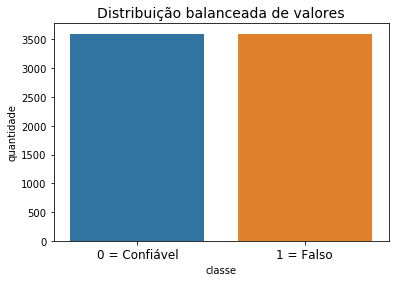

In [3]:
ax = sns.countplot(x="classe", data=dados)
ax.set_xticklabels(["0 = Confiável", "1 = Falso"], fontsize=12)
ax.set_title('Distribuição balanceada de valores', fontsize=14)
ax.set_ylabel('quantidade')
plt.show()

In [4]:
def conta_palavras(texto):
    qtdes = []
    for linha in texto:
        qtdes.append(len(re.findall(r"[\w']+|[.,!?;:/\"]", linha)))
    return np.array(qtdes)

def distribiucao_palavras(dados, campo, titulo):
    contagem = conta_palavras(dados[campo].values)
    intervalo = list(range(0, 601, 50))

    plt.figure(figsize=(8,6))
    plt.rcParams.update({'font.size': 14})
    plt.hist(contagem, rwidth=0.9, edgecolor='black', linewidth=1, bins=intervalo)
    plt.xticks(intervalo)
    plt.title(titulo)
    plt.xlabel("Qtde palavras ou pontuação", fontsize=14, fontweight="bold")
    plt.ylabel("Qtde de amostras", fontsize=14, fontweight="bold")

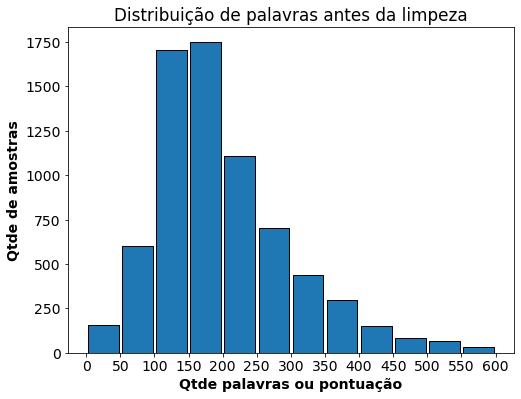

In [5]:
distribiucao_palavras(dados, "texto", "Distribuição de palavras antes da limpeza")

In [6]:
# Limpar textos
def limpar_textos(texto):
    texto = str(texto).replace(r'http[\w:/\.]+', ' ')  # remover urls
    texto = str(texto).replace(r'[^\.\w\s]', ' ')  # remover tudo exceto caracters e pontuação
    # Correção das pontuações duplicadas, há muitos casos no dadaset
    texto = re.sub(r'(\W)(?=\1)', '', str(texto)).replace(". .", ".")
    texto = str(texto).replace('[^a-zA-Z]', ' ')
    texto = str(texto).replace(r'\s\s+', ' ')
    texto = texto.lower().strip()
    return texto

dados["texto_limpo"] = dados.texto.apply(limpar_textos)
dados.sample(n=5)

,texto,classe,texto_limpo
4537,Lindbergh Farias parte pra cima de senador de 81 anos e quase apanha no senado (vídeo). Era pra ser um simples sessão de ética .... isso mesmo que você leu ... ÉTICA.,1,lindbergh farias parte pra cima de senador de 81 anos e quase apanha no senado (vídeo). era pra ser um simples sessão de ética . isso mesmo que você leu . ética.
165,elação Odebrecht: Luiz Marinho é suspeito de ter recebido vantagens indevidas em campanha\n\nEx-prefeito de São Bernardo do Campo teria recebido R$ 550 mil não contabilizados. Assessoria disse que...,0,elação odebrecht: luiz marinho é suspeito de ter recebido vantagens indevidas em campanha\nex-prefeito de são bernardo do campo teria recebido r$ 550 mil não contabilizados. assessoria disse que t...
4410,"Carlinhos prevê novo acidente aéreo envolvendo time de futebol e terremotos em SP. O vidente mais famoso do Brasil, que previu a queda de Dilma Rousseff, fez previsões não muito animadoras para 2...",1,"carlinhos prevê novo acidente aéreo envolvendo time de futebol e terremotos em sp. o vidente mais famoso do brasil, que previu a queda de dilma rousseff, fez previsões não muito animadoras para 20..."
2299,"Como saber se sua dor de cabeça é, na verdade, enxaqueca crônica. Especialista na síndrome explica por que 80% dos casos não são diagnosticados, e como impedir que o problema se torne mais grave.....",0,"como saber se sua dor de cabeça é, na verdade, enxaqueca crônica. especialista na síndrome explica por que 80% dos casos não são diagnosticados, e como impedir que o problema se torne mais grave. ..."
7005,"Ciro Gomes apoiando Dilma? Nada disso. Vejam o que ele fala sobre Lula, Dilma e o PT. Lula fez uma campanha golpista chamada ""FORA FHC"" , disse o ex-ministro Ciro Gomes. Em entrevista para o j...",1,"ciro gomes apoiando dilma? nada disso. vejam o que ele fala sobre lula, dilma e o pt. lula fez uma campanha golpista chamada ""fora fhc"" , disse o ex-ministro ciro gomes. em entrevista para o jorna..."


In [ ]:
# Configuração da lib Spacy
!python -m spacy download pt_core_news_sm
nlp = spacy.load("pt_core_news_sm")

In [8]:
# Processamento com Spacy para Lematização
# Lemmatizer (o resultado é a raiz da palavra que existe na gramática, mantendo o contexto)
# Stemming (palavra resultante pode não existir, apenas reduz a dimencionalidade) 

# Remover stopwords    
dados["texto_sem_stop"] = dados.texto_limpo.apply(lambda texto: 
                                          " ".join(token.text for token in nlp(texto) 
                                                   if not token.is_stop))

# Lematizar
dados["texto_lematizado"] = dados.texto_sem_stop.apply(lambda texto: 
                                          " ".join(token.lemma_ for token in nlp(texto)))

In [9]:
# Confere resultados visualmente
dados.sample(n=5)

,texto,classe,texto_limpo,texto_sem_stop,texto_lematizado
5932,4.500 objetos de valor sumiram do Planalto. Auditoria do TCU aponta que Lula e Dilma burlaram a regra. Aproximadamente 4.500 itens que fazem parte do patrimônio da Presidência da República sumira...,1,4.500 objetos de valor sumiram do planalto. auditoria do tcu aponta que lula e dilma burlaram a regra. aproximadamente 4.500 itens que fazem parte do patrimônio da presidência da república sumiram...,"4.500 objetos sumiram planalto . auditoria tcu aponta lula dilma burlaram regra . aproximadamente 4.500 itens patrimônio presidência república sumiram . informação colunista talita abrantes , revi...","4.500 objetos sumir planalto . auditoria tcu apontar lula dilma burlar regrar . aproximadamente 4.500 item patrimônio presidência repúblico sumir . informação colunista talita abrantes , revisto e..."
1207,Funaro: Temer e Cunha confabulavam diariamente para tramar impeachment de Dilma Rousseff. Informação consta do acordo de delação premiada do homem apontado como operador financeiro de propinas do ...,0,funaro: temer e cunha confabulavam diariamente para tramar impeachment de dilma rousseff. informação consta do acordo de delação premiada do homem apontado como operador financeiro de propinas do ...,funaro : temer cunha confabulavam diariamente tramar impeachment dilma rousseff . informação consta acordo delação premiada homem apontado operador financeiro propinas pmdb . g1 procurou assessori...,funaro : temer cunhar confabular diariamente tramar impeachment dilma rousseff . informação constar acordar delação premiar homem apontar operador financeiro propinar pmdb . g1 procurar assessoria...
5012,"Guido Mantega é hostilizado nas ruas novamente. Lula após a prisão: Humildade, cabeça baixa e braços para trás!. Preso em setembro de 2016 pela Operação Arquivo-X, Mantega é acusado de cometer i...",1,"guido mantega é hostilizado nas ruas novamente. lula após a prisão: humildade, cabeça baixa e braços para trás!. preso em setembro de 2016 pela operação arquivo-x, mantega é acusado de cometer irr...","guido mantega hostilizado ruas novamente . lula prisão : humildade , cabeça baixa braços trás ! . preso setembro 2016 operação arquivo-x , mantega acusado cometer irregularidades contratos assinad...","guido mantega hostilizar ruir novamente . lula prisão : humildade , cabeça baixo braço trás ! . presar setembro 2016 operação arquivo-x , mantega acusar cometer irregularidade contrato assinar pet..."
1676,Polícia Nacional do Paraguai vai investigar se houve participação de policiais em mega-assalto. Decisão foi anunciada nesta quinta-feira (27) durante reunião do Comando Tripartite de Segurança em ...,0,polícia nacional do paraguai vai investigar se houve participação de policiais em mega-assalto. decisão foi anunciada nesta quinta-feira (27) durante reunião do comando tripartite de segurança em ...,polícia nacional paraguai investigar houve participação policiais mega-assalto . decisão anunciada quinta-feira ( 27 ) durante reunião comando tripartite segurança ciudad del . polícia nacional pa...,polícia nacional paraguai investigar haver participação policiar mega-assalto . decisão anunciar quinta-feira ( 27 ) durante reunião comandar tripartite segurança ciudad del . polícia nacional par...
6696,"Dilma terá que explicar para a justiça porque usou Jato da FAB para visitar o amigo ""molusco"". A citação ocorrerá via Justiça Federal em Brasília, para onde a 8.ª Vara Cível Federal de São Paulo...",1,"dilma terá que explicar para a justiça porque usou jato da fab para visitar o amigo ""molusco"". a citação ocorrerá via justiça federal em brasília, para onde a 8.ª vara cível federal de são paulo e...","dilma terá explicar justiça usou jato fab visitar amigo "" molusco "" . citação ocorrerá via justiça federal brasília , 8.ª vara cível federal paulo expediu carta precatória . presidenta terá explic...","dilma ter explicar justiçar usar jato fab visitar amigar "" molusco "" . citação ocorre

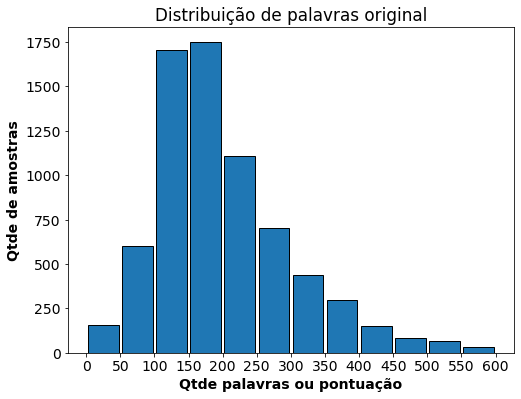

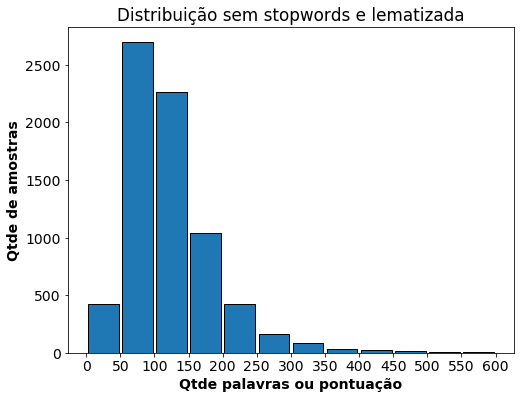

In [11]:
distribiucao_palavras(dados, "texto", "Distribuição de palavras original")
distribiucao_palavras(dados, "texto_lematizado", "Distribuição sem stopwords e lematizada")

In [ ]:
# initialize the word cloud
wordcloud = WordCloud( background_color='black', width=800, height=600)
# generate the word cloud by passing the corpus
text_cloud = wordcloud.generate(' '.join(dados['text']))
# plotting the word cloud
plt.figure(figsize=(20,30))
plt.imshow(text_cloud)
plt.axis('off')
plt.show()

In [ ]:
# Salva dados para uso no notebook do próximo passo.
dados.to_csv('dados/fakebr_corpus_processado.csv', sep = ',', index = True)